In [1]:
import serial
import time
import re
import pandas as pd
import numpy as np
import pickle
import json

from IPython.display import IFrame
import serial.tools.list_ports

import pickle
import numpy as np
from pyargus.directionEstimation import *

import math
from collections import deque
from scipy.spatial import distance

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import MultipleLocator
from matplotlib.collections import PatchCollection

import matplotlib.colors as mcolors
import pydbus
from time import sleep
import matplotlib
import colorsys
import math
import random

In [2]:
class Candidate():
    
    def __init__(self):
        super(Candidate, self).__init__()
        self.width = 7
        self.height = 5.4
        self.spacing = 0.5
        self.total_directions = 8
        self.degree_adjust = 0
        
        self.color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) 
                      for i in range(32)]

        
    def configure(self):
        self.x_range = np.arange(-self.width, self.width, self.spacing)
        self.y_range = np.arange(-self.height, self.height, self.spacing)
        
        self.x_map = np.arange(0, self.width, self.spacing)
        self.y_map = np.arange(0, self.height, self.spacing)
    
    def search_insert_position(self, nums, target):
        left = 0
        right = len(nums) - 1
        
        while left <= right:
            mid = (left + right) // 2
            
            if nums[mid] == target:
                return mid
            elif target > nums[mid]:
                left = mid + 1
            else:
                right = mid - 1
        
        return right

    
    def get_candidate(self, device_coord, direction):
        adjust = math.radians(self.degree_adjust)
        candidates = []

        for x in self.x_range:
            for y in self.y_range:
                sliceno = np.int32((math.pi + adjust + np.arctan2(y, x)) * (self.total_directions / (2*math.pi)))
                
                if sliceno>=self.total_directions:
                    sliceno = 0
                            
                if sliceno == direction:
                    x_coord = x + device_coord[0]
                    y_coord = y + device_coord[1]
                    
                    if x_coord>=0 and y_coord>=0 and x_coord<self.width and y_coord<self.height: 
                        x_coord = self.search_insert_position(self.x_map, x_coord)
                        y_coord = self.search_insert_position(self.y_map, y_coord)
                     
                        candidates.append((x_coord, y_coord))    
                        
        candidates =  [*set(candidates)] #remove duplicates
        candidates = list(filter(lambda item: item is not None, candidates)) #remove null
        
        return candidates
    
    
    def visualize_single_strip(self, candidates, color, ax):
        for i in self.x_range:
            ax.axvline(x = i, color = 'black', linewidth=0.05, alpha=0.9)
        
        for i in self.y_range:
            ax.axhline(y = i, color = 'black', linewidth=0.05, alpha=0.9)
        
        rects = []

        for x,y in candidates:
            rect = Rectangle((self.x_map[x], self.y_map[y]), self.spacing, self.spacing, 
                             color=color, alpha=1)
            rects.append(rect)

        ax.add_collection(PatchCollection(rects, match_original=True))
        
        plt.gca().invert_xaxis()
        plt.gca().invert_yaxis()
        
        ax.set_xlim([0, self.width])
        ax.set_ylim([0, self.height])
        
        
    def get_coord(self, x, y):
        
        rect_x = self.search_insert_position(self.x_map, x)
        rect_y = self.search_insert_position(self.y_map, y)   

        return rect_x, rect_y
    
    

## Static test

In [ ]:
c = Candidate()
c.spacing = 0.2
c.degree_adjust = 0
c.total_directions = 16
c.configure()

fig, axs = plt.subplots(1, 1, figsize=(6, 6))

candidates = c.get_candidate([6,4], 13)
c.visualize_single_strip(candidates, c.color[0], axs)

plt.show()

## Visualize

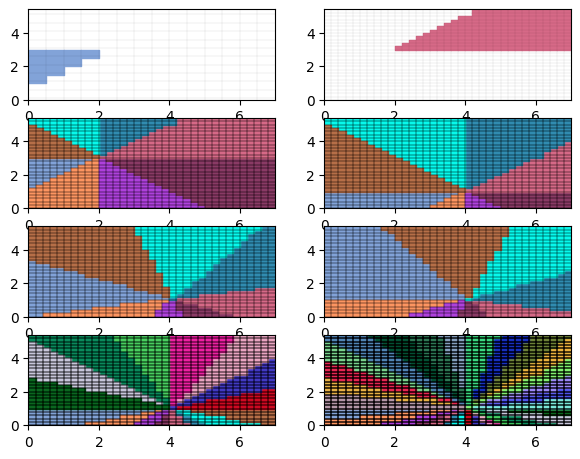

In [4]:
c = Candidate()

fig, axs = plt.subplots(4, 2, figsize=(7, 5.4))

#Default configuration, total_directions=8, spacing = 0.5
c.configure()
candidates = c.get_candidate([2,3], 0)
c.visualize_single_strip(candidates, c.color[0], axs[0, 0])

#total_directions=8, spacing = 0.2
c.spacing = 0.2
c.configure()
candidates = c.get_candidate([2,3], 4)
c.visualize_single_strip(candidates, c.color[4], axs[0, 1])

#total_directions=8, spacing = 0.2
for i in range(c.total_directions):
    candidates = c.get_candidate([2,3], i)
    c.visualize_single_strip(candidates, c.color[i], axs[1, 0],)
    
#total_directions=8, spacing = 0.2
c.total_directions = 8
c.configure()
for i in range(c.total_directions):
    candidates = c.get_candidate([4,1], i)
    c.visualize_single_strip(candidates, c.color[i], axs[1, 1])

#total_directions=4, spacing = 0.2
c.degree_adjust = 30
c.total_directions = 8
c.configure()
for i in range(c.total_directions):
    candidates = c.get_candidate([4,1], i)
    c.visualize_single_strip(candidates, c.color[i], axs[2, 0])
    
#total_directions=4, spacing = 0.2
c.degree_adjust = 60
c.total_directions = 8
c.configure()
for i in range(c.total_directions):
    candidates = c.get_candidate([4,1], i)
    c.visualize_single_strip(candidates, c.color[i], axs[2, 1])

#total_directions=16, spacing = 0.2
c.total_directions = 16
c.degree_adjust = 0
c.configure()
for i in range(c.total_directions):
    candidates = c.get_candidate([4,1], i)
    c.visualize_single_strip(candidates, c.color[i], axs[3, 0])
     
#total_directions=32, spacing = 0.2
c.total_directions = 32
c.degree_adjust = 0
c.configure()
for i in range(c.total_directions):
    candidates = c.get_candidate([4,1], i)
    c.visualize_single_strip(candidates, c.color[i], axs[3, 1])
    
    
plt.show()

## Live test

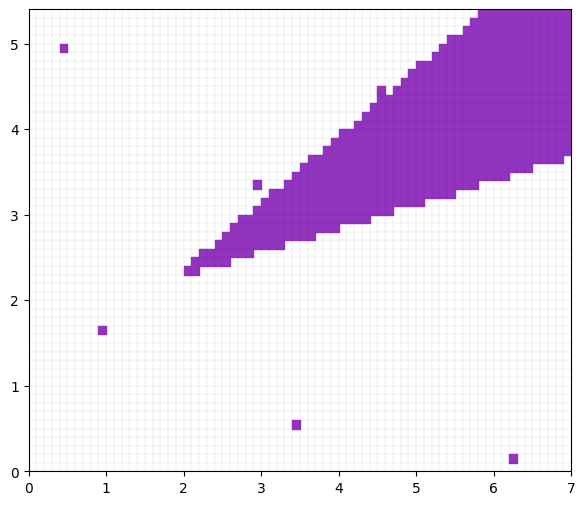

In [ ]:
%run ../featurizer.ipynb
%run ../direction.ipynb
%run ../utils.ipynb
%run ../location.ipynb

f = Featurizer()
f.set_utils(location_id='Arena', user_id='user_01')

c = Candidate()
c.spacing = 0.1
c.total_directions = 16
c.configure()

c.degree_adjust = 7
offset = 8

while True:
    
    direction = f.get_direction().values[0][0]
    direction_class = int((direction*(c.total_directions))/360)

    if direction_class!=0:
        direction_class = c.total_directions - direction_class

    direction_class = (direction_class+offset)%c.total_directions

    fig, axs = plt.subplots(1, 1, figsize=(7, 6))
    
    coord=f.get_location()
    coord = coord.loc[0, :].values.tolist()

    candidates = c.get_candidate(coord, direction_class)

    candidates.append(c.get_coord(.95, 1.6))
    candidates.append(c.get_coord(.44, 4.92))
    candidates.append(c.get_coord(2.98, 3.32))
    candidates.append(c.get_coord(4.6, 4.41))
    candidates.append(c.get_coord(3.45, 0.6))
    candidates.append(c.get_coord(6.62, 4.47))
    candidates.append(c.get_coord(6.3, 0.17))
    

    c.visualize_single_strip(candidates, c.color[0], axs)

    clear_output(wait=True)
    plt.show()
    

print(c.get_coord(6.52, 2.85), direction_class)